In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

import sys
sys.path.append('..')

from lib.utils import format_number, get_color, momentum

SEED = 42
np.random.seed(SEED)

In [2]:
def transform_data(df):
    print('Set model columns...')

    df = df.rename(columns={
        'account_id': 'cid',
        'period_at': 'tp',
        'started_at': 'ts',
        'ended_at': 'te'
    })
    df['tp'] = pd.to_datetime(df['tp'])
    df['ts'] = pd.to_datetime(df['ts'])
    df['te'] = pd.to_datetime(df['te'])

    df['tfs'] = np.asfarray(np.diff(df[['ts', 'tp']].values.astype('datetime64[M]'), axis=1).flatten().tolist())
    df['tte'] = np.asfarray(np.diff(df[['tp', 'te']].values.astype('datetime64[M]'), axis=1).flatten().tolist())
    df['tte'] = df['tte'].fillna(-1)

    print('Set customer sequence numeric IDs...')

    df['id'] = df.groupby(['cid', 'ts']).ngroup().values
    df['id'] += 1

    print('Customer features...')

    df['country_es'] = (df['country'] == 'es').astype(int)
    df['country_mx'] = (df['country'] == 'mx').astype(int)
    df['country_latam'] = (df['country'].isin(['co', 'cl', 'pe', 'ar', 'ec'])).astype(int)
    df['gateway_auto'] = (~df['gateway'].isin(['debit', 'transfer'])).astype(int)

    df['plan'] = np.select([
        df['mrr'] < 1,
        (1 <= df['mrr']) & (df['mrr'] < 14),
        (14 <= df['mrr']) & (df['mrr'] < 34),
        (34 <= df['mrr']) & (df['mrr'] < 64),
        (64 <= df['mrr']) & (df['mrr'] < 94),
    ], [0, 1, 2, 3, 4], default=5)

    df['usage'] = np.select([
        df['events'] < 5,
        (5 <= df['events']) & (df['events'] < 60),
        (60 <= df['events']) & (df['events'] < 180),
        (180 <= df['events']) & (df['events'] < 360),
        (360 <= df['events']) & (df['events'] < 720),
    ], [0, 1, 2, 3, 4], default=5)
    df['active'] = df['usage'] > 1

    df['usage_groups'] = np.select([
        df['events_groups'] < 5,
        (5 <= df['events_groups']) & (df['events_groups'] < 30),
        (30 <= df['events_groups']) & (df['events_groups'] < 90),
        (90 <= df['events_groups']) & (df['events_groups'] < 180),
        (180 <= df['events_groups']) & (df['events_groups'] < 360),
    ], [0, 1, 2, 3, 4], default=5)
    df['active_groups'] = df['usage_groups'] > 1

    df['usage_payments'] = np.select([
        df['events_payments'] < 5,
        (5 <= df['events_payments']) & (df['events_payments'] < 30),
        (30 <= df['events_payments']) & (df['events_payments'] < 90),
        (90 <= df['events_payments']) & (df['events_payments'] < 180),
        (180 <= df['events_payments']) & (df['events_payments'] < 360),
    ], [0, 1, 2, 3, 4], default=5)
    df['active_payments'] = df['usage_payments'] > 1

    print('New window agg features...')

    df[[
        'usage_avg', 'usage_groups_avg', 'usage_payments_avg', 'paid_periods', 'failed_periods', 'active_periods'
    ]] = df.sort_values('tp').groupby('id').expanding().agg({
        'usage': 'mean',
        'usage_groups': 'mean',
        'usage_payments': 'mean',
        'pay': 'sum',
        'failed': 'sum',
        'active': 'sum'
    }).round(2).values

    print('Usage momentum...')

    df['momentum'] = df.sort_values('tp').groupby('id')['events'].apply(
        momentum, deg=3, span=2, log=True
    ).explode().fillna(0).clip(-100, 100).round(2).values

    print('Usage features...')

    df['months'] = df['tfs']
    df['failed_ratio'] = np.where(
        df['paid_periods'] > 0,
        df['failed_periods'] / df['paid_periods'],
        np.NaN
    ).round(2)
    df['usage_diff'] = (df['usage'] - df['usage_avg']).round(2)

    print('Sort and select columns...')

    df = df.sort_values(['id', 'tp'])[[
        'cid', 'id', 'tp', 'tfs', 'tte', 'ts', 'te',
        'employees', 'mrr', 'value', 'interval', 'due', 'pay', 'gift', 'failed', 'events', 'events_groups', 'events_payments',
        'country_es', 'country_mx', 'country_latam', 'gateway_auto',
        'plan', 'usage', 'active', 'usage_groups', 'active_groups', 'usage_payments', 'active_payments',
        'usage_avg', 'usage_groups_avg', 'usage_payments_avg', 'paid_periods', 'failed_periods', 'active_periods',
        'momentum', 'months', 'failed_ratio', 'usage_diff'
    ]]

    return df

In [3]:
data_fit = pd.read_csv('../files/data/churn-data-fit.csv')

df = transform_data(data_fit)
df.to_csv('../files/churn-data-fit.csv', index=False)

clear_output(wait=True)

cs = (df.sort_values(['id', 'tfs']).groupby('id')['tte'].last() < 0).value_counts().sort_index().astype(float)
print('Total Customers: {} | Censored: {} | Non-censored: {} | Censored Rate {}%'.format(
    format_number(cs.sum()),
    format_number(cs[1]),
    format_number(cs[0]),
    format_number(100 * cs[1] / cs.sum(), 2)
))

df

Total Customers: 11.069 | Censored: 2.678 | Non-censored: 8.391 | Censored Rate 24,19%


,cid,id,tp,tfs,tte,ts,te,employees,mrr,value,...,usage_avg,usage_groups_avg,usage_payments_avg,paid_periods,failed_periods,active_periods,momentum,months,failed_ratio,usage_diff
0,51b46d18c4de615d0f000019,1,2017-07-01,4.0,-1.0,2017-03-01,NaT,1,26.58,159.50,...,2.00,0.0,0.0,0.0,0.0,1.0,0.00,4.0,NaN,0.00
1,51b46d18c4de615d0f000019,1,2017-08-01,5.0,-1.0,2017-03-01,NaT,1,26.58,159.50,...,2.00,0.0,0.0,0.0,0.0,2.0,1.20,5.0,NaN,0.00
2,51b46d18c4de615d0f000019,1,2017-09-01,6.0,-1.0,2017-03-01,NaT,1,26.58,239.25,...,2.00,0.0,0.0,1.0,0.0,3.0,-3.14,6.0,0.0,0.00
3,51b46d18c4de615d0f000019,1,2017-10-01,7.0,-1.0,2017-03-01,NaT,1,26.58,239.25,...,1.75,0.0,0.0,1.0,0.0,3.0,-13.60,7.0,0.0,-0.75
4,51b46d18c4de615d0f000019,1,2017-11-01,8.0,-1.0,2017-03-01,NaT,1,26.58,239.25,...,1.60,0.0,0.0,1.0,0.0,3.0,-18.57,8.0,0.0,-0.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201230,66633bcee489710bb6afe3d9,11065,2024-06-01,0.0,-1.0,2024-06-01,NaT,1,101.97,101.97,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00
201231,666346aee489710bb6afead3,11066,2024-06-01,0.0,-1.0,2024-06-01,NaT,1,40.00,40.00,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00
201232,66634aea1e0bd65a73bf4f2f,11067,2024-06-01,0.0,-1.0,2024-06-01,NaT,1,46.62,46.62,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00
201233,666388b3e489710bb6b00925,11068,2024-06-01,0.0,-1.0,2024-06-01,NaT,1,60.19,60.19,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00


In [4]:
data_predict = pd.read_csv('../files/data/churn-data-predict.csv')

dp = transform_data(data_predict)
dp.to_csv('../files/churn-data-predict.csv', index=False)

clear_output(wait=True)

print('Total Customers: {}'.format(
    format_number(len(dp['id'].unique()))
))

dp

Total Customers: 2.684


,cid,id,tp,tfs,tte,ts,te,employees,mrr,value,...,usage_avg,usage_groups_avg,usage_payments_avg,paid_periods,failed_periods,active_periods,momentum,months,failed_ratio,usage_diff
0,51b46d18c4de615d0f000019,1,2017-07-01,4.0,-1.0,2017-03-01,NaT,1,26.58,159.50,...,2.00,0.0,0.0,0.0,0.0,1.0,0.00,4.0,NaN,0.00
1,51b46d18c4de615d0f000019,1,2017-08-01,5.0,-1.0,2017-03-01,NaT,1,26.58,159.50,...,2.00,0.0,0.0,0.0,0.0,2.0,1.20,5.0,NaN,0.00
2,51b46d18c4de615d0f000019,1,2017-09-01,6.0,-1.0,2017-03-01,NaT,1,26.58,239.25,...,2.00,0.0,0.0,1.0,0.0,3.0,-3.14,6.0,0.0,0.00
3,51b46d18c4de615d0f000019,1,2017-10-01,7.0,-1.0,2017-03-01,NaT,1,26.58,239.25,...,1.75,0.0,0.0,1.0,0.0,3.0,-13.60,7.0,0.0,-0.75
4,51b46d18c4de615d0f000019,1,2017-11-01,8.0,-1.0,2017-03-01,NaT,1,26.58,239.25,...,1.60,0.0,0.0,1.0,0.0,3.0,-18.57,8.0,0.0,-0.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,66633bcee489710bb6afe3d9,2680,2024-06-01,0.0,-1.0,2024-06-01,NaT,1,101.97,101.97,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00
101762,666346aee489710bb6afead3,2681,2024-06-01,0.0,-1.0,2024-06-01,NaT,1,40.00,40.00,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00
101763,66634aea1e0bd65a73bf4f2f,2682,2024-06-01,0.0,-1.0,2024-06-01,NaT,1,46.62,46.62,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00
101764,666388b3e489710bb6b00925,2683,2024-06-01,0.0,-1.0,2024-06-01,NaT,1,60.19,60.19,...,0.00,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.00


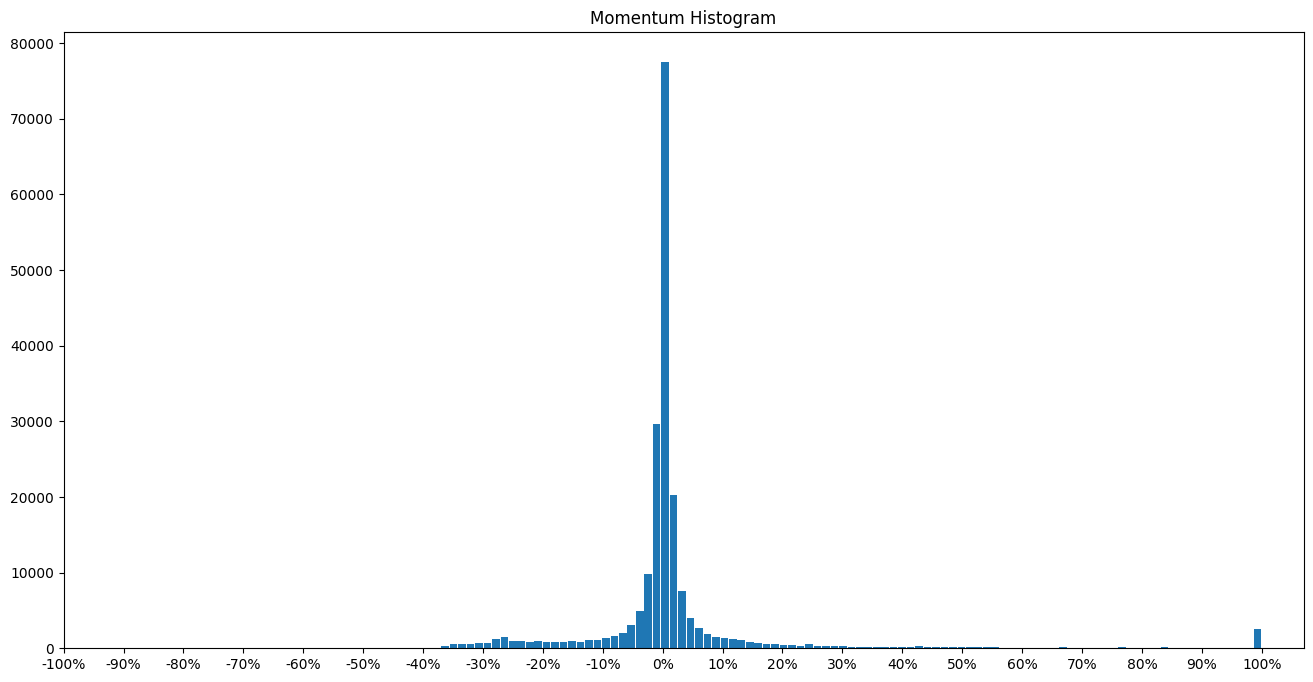

In [5]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.hist(
    df['momentum'], bins=100, color=get_color('blue'), rwidth=0.9
)

ax.set_xticks(np.arange(-100, 110, 10))
ax.set_xticklabels([f'{i}%' for i in ax.get_xticks()])

ax.set_title('Momentum Histogram')

plt.show()

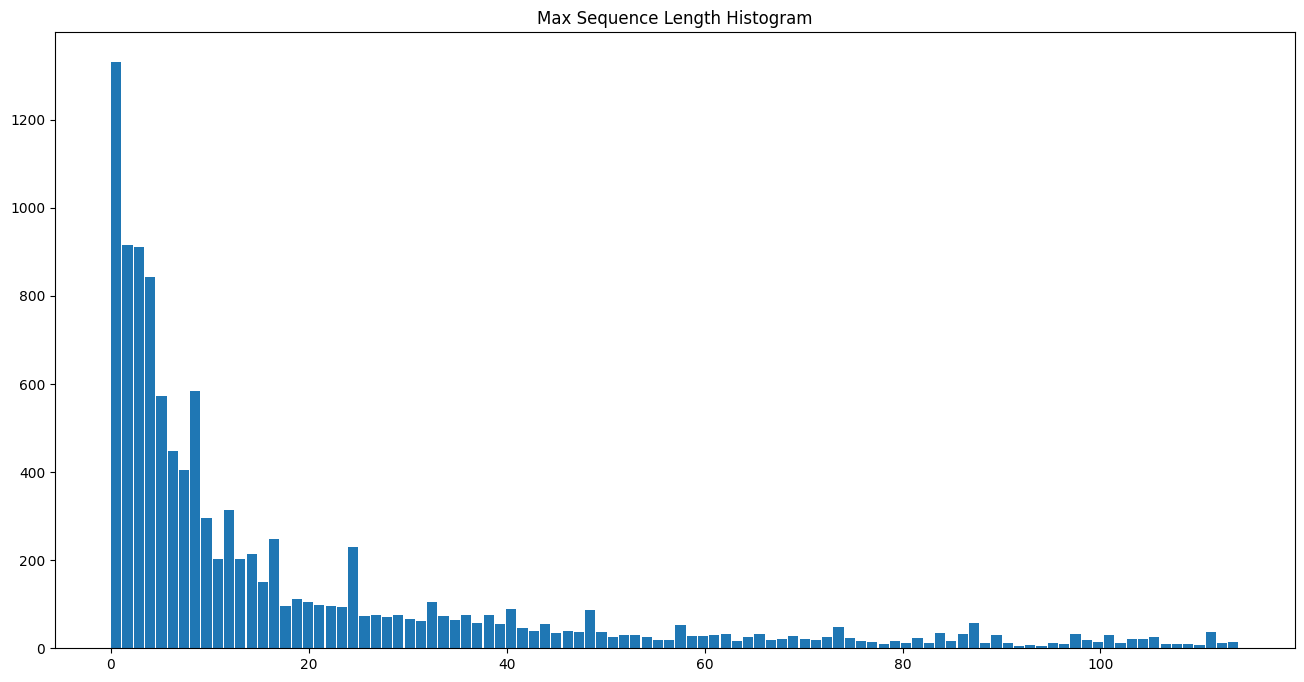

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.hist(
    df.groupby('id')['tfs'].max(), bins=100, color=get_color('blue'), rwidth=0.9
)

ax.set_title('Max Sequence Length Histogram')

plt.show()

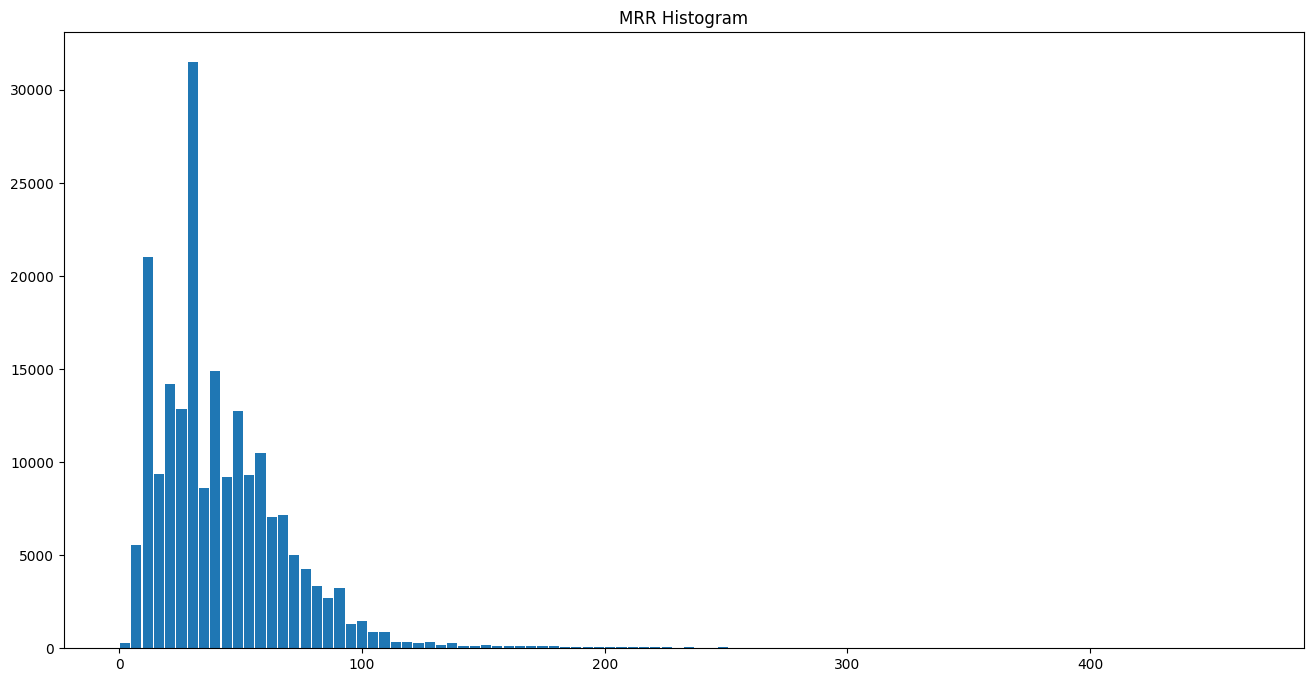

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.hist(
    df['mrr'], bins=100, color=get_color('blue'), rwidth=0.9
)

ax.set_title('MRR Histogram')

plt.show()

In [8]:
n_samples = 6
min_periods = 6

dg = df.groupby('id')['active'].sum()
ids = shuffle(
    dg[dg > min_periods].index.tolist(),
    random_state=SEED
)[:n_samples]

print(ids)

[6824, 6854, 5032, 7732, 7885, 7967]


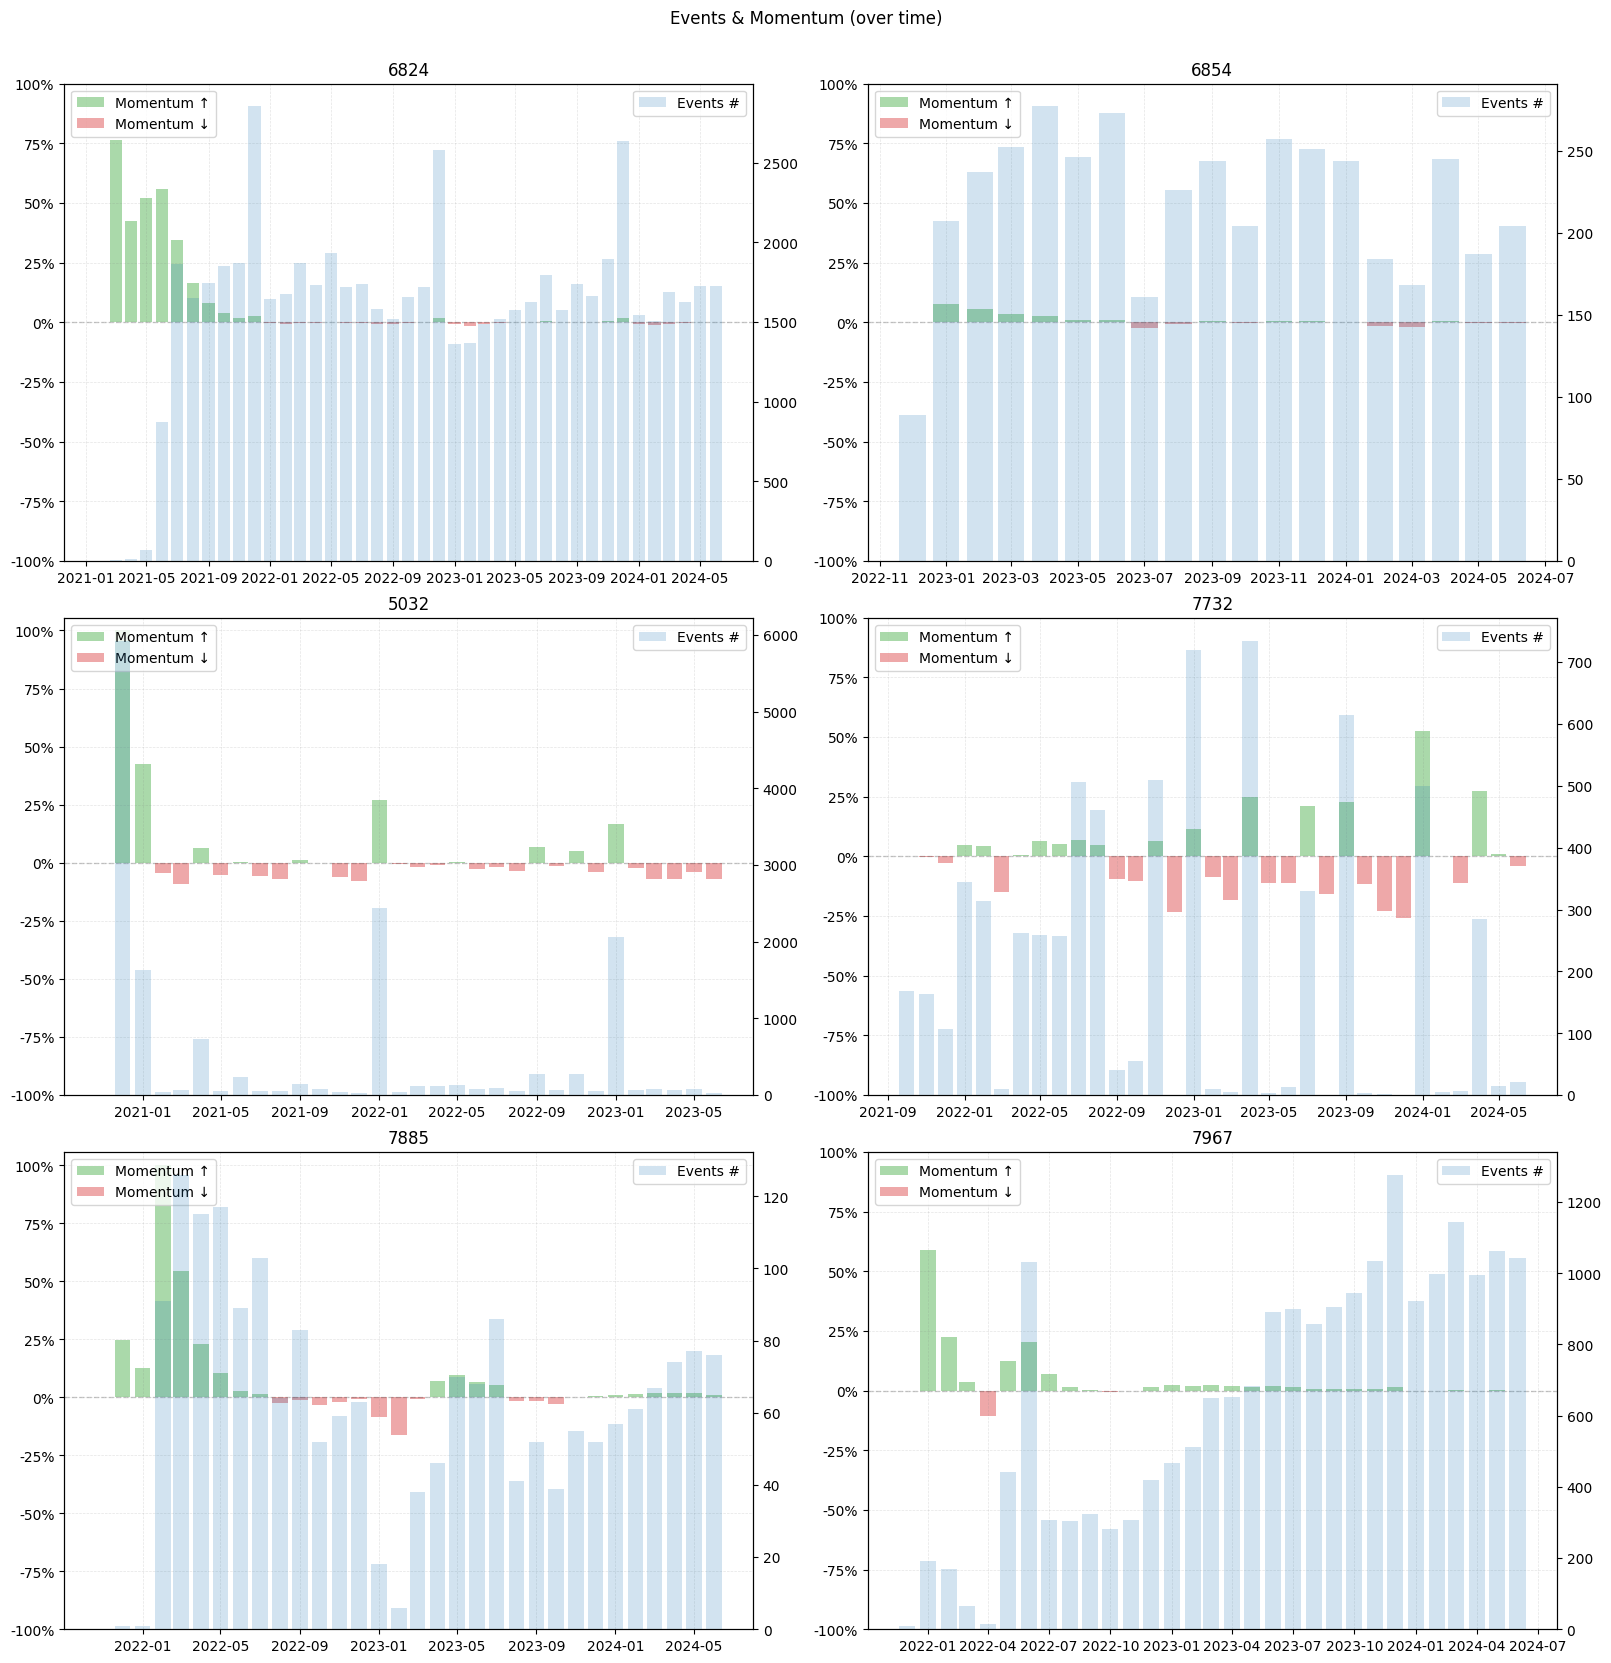

In [9]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16, 16), constrained_layout=True)
axs = axs.flatten()

for i, uid in enumerate(ids):
    d_ = df[df['id'] == uid].set_index('tp')[['momentum', 'events']]
    d_['mom_pos'] = [i if i > 0 else np.NaN for i in d_['momentum']]
    d_['mom_neg'] = [i if i < 0 else np.NaN for i in d_['momentum']]
    d_ = d_.drop(columns=['momentum'])[['mom_pos', 'mom_neg', 'events']]

    ax = axs[i]
    ax2 = ax.twinx()

    ax.bar(
        d_.index, d_['mom_pos'], width=24, color=get_color('green'), alpha=0.4, label='Momentum ↑'
    )
    ax.bar(
        d_.index, d_['mom_neg'], width=24, color=get_color('red'), alpha=0.4, label='Momentum ↓'
    )
    ax2.bar(
        d_.index, d_['events'], width=24, color=get_color('blue'), alpha=0.2, label='Events #'
    )

    ax.axhline(0, color='k', ls='--', lw=1, alpha=0.2)

    ax.set_yticks([-100, -75, -50, -25, 0, 25, 50, 75, 100])
    ax.set_yticklabels([f'{i}%' for i in ax.get_yticks()])

    ax.grid(True, ls='--', lw=.5, color=get_color('grey'), alpha=0.2)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

    ax.set_title(uid)

plt.suptitle('Events & Momentum (over time)', y=1.03)

plt.show()